<a href="https://colab.research.google.com/github/mhuckvale/pals0039/blob/master/Exercise_8_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![PALS0039 Logo](https://www.phon.ucl.ac.uk/courses/pals0039/images/pals0039logo.png)](https://www.phon.ucl.ac.uk/courses/pals0039/)

# Exercise 8.3 

In this exercise we build a simple German to English machine translation system based on an English-German phrase dictionary. 

We approach the task as a sequence-to-sequence problem, with an encoder which generates a sentence embedding from the input, and a decoder which generates the translation from the embedding word by word. Each decoder time step takes as input the whole sentence embedding, the previous output symbol and the RNN state from the previous output.

This exercise also demonstrates how the BLEU metric can be used to score the performance of machine translation.

The implementation uses a simple Sequential DNN model implemeted in Keras and was developed from [https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/](https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/)

(a) Setup libraries

In [1]:
# import libraries
import string
import re
from pickle import load
from pickle import dump
from unicodedata import normalize
from numpy import array
import requests
from numpy.random import rand
from numpy.random import shuffle
from numpy import argmax

# import Keras functions
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# import BLEU calculator from NLTK
from nltk.translate.bleu_score import corpus_bleu


---
(b) Load the phrase dictionary.

In [2]:
# function to read the phrase dictionary into a text buffer, using UTF-8 coding
def load_doc(url):
  response = requests.get(url)
  response.encoding='utf-8'
#  response.text
  print("Corpus has",len(response.text),"characters")
  print(response.text[:250])
  return response.text
 
# function to divide text up into pairs of English and German phrases
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t')[:2] for line in  lines]
	return pairs
 
# function to tidy up and normalise the phrases
def clean_pairs(lines):
  cleaned = list()
	# make a character translation table 
  table = str.maketrans('', '', string.punctuation)
  # process all pairs
  for pair in lines:
    clean_pair = list()
    for phrase in pair:
			# divide into words 
      words = phrase.split()
      # convert to lowercase
      words = [word.lower() for word in words]
      # eliminate punctuation
      words = [word.translate(table) for word in words]
      # save cleaned words
      clean_pair.append(' '.join(words))
    # add cleaned pair back to list  
    cleaned.append(clean_pair)
  return array(cleaned)
 
# save the data to file system
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load the phrase book
url = 'https://www.phon.ucl.ac.uk/courses/pals0039/data/deu-eng.txt'
doc = load_doc(url)

# convert to pairs
pairs = to_pairs(doc)

# clean the pairs
clean_pairs = clean_pairs(pairs)

# save the cleaned pairs
save_clean_data(clean_pairs, 'english-german.txt')

# print out a sample
for i in (1,10,100,1000,10000,100000):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Corpus has 31279287 characters
﻿Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)
Hi.	Grüß Gott!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)
Run!	Lauf!	CC-BY 2.0 (France) Attribution: tatoeba.org #90632
Saved: english-german.txt
[hi] => [grüß gott]
[go on] => [mach weiter]
[get out] => [geh raus]
[can i help] => [kann ich mich nützlich machen]
[get off my lawn] => [gehen sie von meinem rasen]
[i intend to stay a whole week] => [ich habe die absicht eine ganze woche zu bleiben]


---
(c) Prepare data for training.

In [3]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
raw_dataset = load_clean_sentences('english-german.txt')
 
# limit dataset size to speed up training in demonstration
n_sentences = 100000
dataset = raw_dataset[:n_sentences, :]

# random shuffle
shuffle(dataset)

# split into train/test
ntest=dataset.shape[0]//20
train, test = dataset[:-ntest], dataset[-ntest:]
print("Train",train.shape,"Test",test.shape)

# save
save_clean_data(dataset, 'english-german-both.txt')
save_clean_data(train, 'english-german-train.txt')
save_clean_data(test, 'english-german-test.txt')

# clean up unused variables
del raw_dataset
del dataset

Train (95000, 2) Test (5000, 2)
Saved: english-german-both.txt
Saved: english-german-train.txt
Saved: english-german-test.txt


---
(d) Tokenize the English and German sentences.

In [4]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# find max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# load datasets
dataset = load_clean_sentences('english-german-both.txt')
train = load_clean_sentences('english-german-train.txt')
test = load_clean_sentences('english-german-test.txt')
 
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# free the dataset
del dataset 

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare test data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])



English Vocabulary Size: 9496
English Max Length: 9
German Vocabulary Size: 17285
German Max Length: 18


---
(e) Build the translation model. This uses an LSTM to return a sentence encoding of the source sentence, then replicates that encoding on the input to an LSTM that generates the target sentence.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18, 256)           4424960   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 9, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 9, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 9496)           2440472   
Total params: 7,916,056
Trainable params: 7,916,056
Non-trainable params: 0
_________________________________________________________________
None


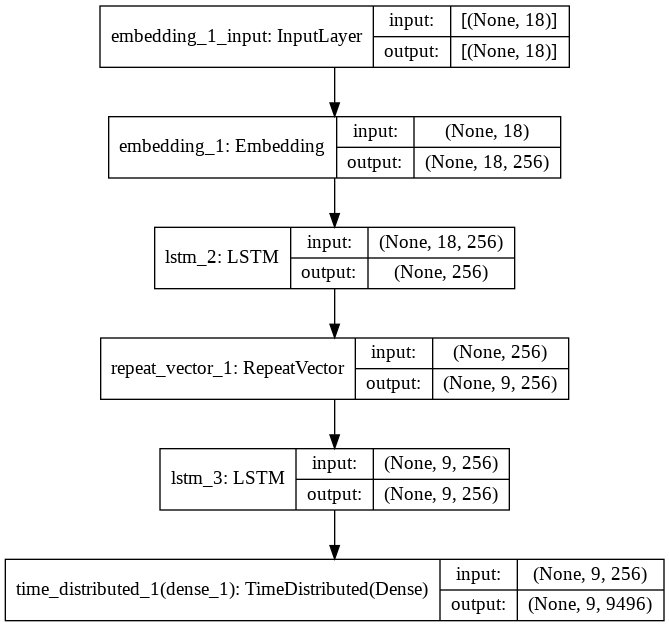

In [7]:
# define the encoder-decoder model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	# layer 1 is an embedding of the input words
	model.add(Embedding(src_vocab, 256, input_length=src_timesteps))
	# layer 2 creates sentence embedding
	model.add(LSTM(n_units))
	# the embedding is then replicated over all the output timesteps
	model.add(RepeatVector(tar_timesteps))
	# layer 3 unpacks the embedding
	model.add(LSTM(n_units, return_sequences=True))
	# layer 4 computes a pdf over the output vocabulary
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# create a german to english translation model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# summarise the model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

---
(f) Fit model to phrases. Training takes about 60min. Run the code and add comments.

In [8]:
# because training takes time, we checkpoint the model during training
# this saves the partially trained model any time that the validation loss is reduced
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# 
history=model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/50
1485/1485 - 74s - loss: 3.3428 - val_loss: 3.1759

Epoch 00001: val_loss improved from inf to 3.17591, saving model to model.h5
Epoch 2/50
1485/1485 - 71s - loss: 3.1560 - val_loss: 3.1546

Epoch 00002: val_loss improved from 3.17591 to 3.15461, saving model to model.h5
Epoch 3/50
1485/1485 - 72s - loss: 3.1362 - val_loss: 3.1466

Epoch 00003: val_loss improved from 3.15461 to 3.14660, saving model to model.h5
Epoch 4/50
1485/1485 - 72s - loss: 3.1258 - val_loss: 3.1457

Epoch 00004: val_loss improved from 3.14660 to 3.14572, saving model to model.h5
Epoch 5/50
1485/1485 - 71s - loss: 3.1193 - val_loss: 3.1431

Epoch 00005: val_loss improved from 3.14572 to 3.14315, saving model to model.h5
Epoch 6/50
1485/1485 - 72s - loss: 3.1149 - val_loss: 3.1440

Epoch 00006: val_loss did not improve from 3.14315
Epoch 7/50
1485/1485 - 71s - loss: 3.1118 - val_loss: 3.1455

Epoch 00007: val_loss did not improve from 3.14315
Epoch 8/50
1485/1485 - 70s - loss: 3.1224 - val_loss: 5.0763

E

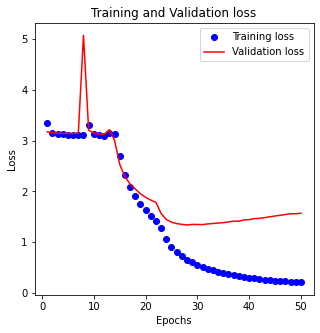

In [11]:
# get the history dictionary 
hist=history.history
epochs=range(1,len(hist['loss'])+1)

import matplotlib.pyplot as plt
%matplotlib inline

# plot loss curves
plt.figure(figsize=(5,5))
plt.plot(epochs,hist['loss'],'bo',label="Training loss")
plt.plot(epochs,hist['val_loss'],'r-',label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


---
(g) Evaluate model on both training and test sentences. The code does take some minutes to run and calculate the BLEU scores. Run the code and add comments.

In [12]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the performance of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
  actual, predicted = list(), list()
  for i, source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    raw_target, raw_src = raw_dataset[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
    actual.append([raw_target.split()])
    predicted.append(translation.split())

  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('english-german-both.txt')
train = load_clean_sentences('english-german-train.txt')
test = load_clean_sentences('english-german-test.txt')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])

# prepare samples of train and test data for evaluation
trainX = encode_sequences(ger_tokenizer, ger_length, train[:7500, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('model.h5')

# test on some training sequences
print('***** train')
evaluate_model(model, eng_tokenizer, trainX, train)

# test on some test sequences
print('***** test')
evaluate_model(model, eng_tokenizer, testX, test)


***** train
src=[tom ist sehr hartnäckig], target=[tom is very persistent], predicted=[tom is very very]
src=[warum fahrt ihr nicht mit dem taxi], target=[why dont you take a taxi], predicted=[why dont you take a taxi]
src=[keiner kann euch helfen], target=[nobody can help you], predicted=[no one can help you]
src=[mein rücken schmerzt], target=[my back hurts], predicted=[my back hurts]
src=[tom wusch sich nicht die hände], target=[tom didnt wash his hands], predicted=[tom didnt wash hands]
src=[den typen kenne ich], target=[i know that guy], predicted=[i know that guy]
src=[jesus wurde in bethlehem geboren], target=[jesus was born in bethlehem], predicted=[he was born in bethlehem]
src=[ich bin dir böse], target=[im mad at you], predicted=[im angry with you]
src=[du bist sehr reich], target=[you are very rich], predicted=[youre are very rich]
src=[feier schön], target=[have fun], predicted=[have fun]
BLEU-1: 0.769163
BLEU-2: 0.679304
BLEU-3: 0.631712
BLEU-4: 0.526013
***** test
src=[i

---
(h) Experiment with different amounts of training data and different network configurations. What is the best BLEU score you can obtain on the test set?